# Exploration

## Table of Contents

1. [Overview](##1.-Overview)
2. [Tools](##2.-Tools)
3. [Exploration](##3.-Exploration)
    - [Extract](###3.1-Extract)
    - [Transform](###3.2-Transform)
    - [Load](###3.3-Load)
4. Evaluation Analysis
    - Confusion Matrix
    - Precision
    - Recall
    - F1 Score
    - Accuracy
    - Specificity
    - Autoevaluation
5. Building a Pipeline
6. Tests
7. Conclusion

## 1. Overview

**Task:**

The labellers have reviewed the output of a model, and now we would like to compare its performance against the ground truth. Attached are the results of the model run on 752 images, as well as the labels generated by the labellers. Each file lists the predictions of a single microscope image, with the filename denoting the image id. We would now like to compare the difference between the two datasets. Please write an efficient code base to output the F1 Score, Accuracy, Precision and Confusion Matrix of the dataset.

**Inputs:**
- Zip Folder
- Folder titled "predictions"
- JSON file describing predicted bounding boxes for a particular microscope image.
- Folder titled "Ground Truth"
- JSON file describing ground truth bounding boxes for a particular microscope image.

**Outputs:**
- F1 Score
- Accuracy
- Precision
- Confusion Matrix
- Code used to generate the outputs

**Submission**
There are two ways to submit your code:
1. Upload your repo to Github. Add ‘BioScout-Tom’ and ‘eltuna9’ as viewers to your repo.
2. Use git bundle to create a single file of your repo, and reply to this email with the bundle attached.

**Expectations:**
- When using a Jupyter notebook, please use markdown to clearly document each section.
- When using raw python, please make sure to commit frequently with clear commit messages, and to send through the bundled code.
- Bonus: Extra points for any other metrics that you believe would be useful for measuring the performance of the model.

**Goals:**
In this question, we hope for you to demonstrate your knowledge of Python applied to a common ML data wrangling task, as well as modern software development practices.

## 2. Tools

To get started, we'll begin by importing a few packages that will help us carry out the tasks above. The two packages not in the standard library are:
- `pandas`
- `scikit-learn`
- `ibis`
- `dvc`

In [132]:
import pandas as pd
import json
from pprint import pprint
from glob import glob
from os.path import join
from random import choice
from sklearn import metrics as m
import ibis

## 3. Exploration

Let's begin by grabbing all of the files in each directory and evaluating a random sample.

In [152]:
actuals = glob(join("data", "raw", "ground_truth", "*.json"))
predicted = glob(join("data", "raw", "predictions", "*.json"))
predicted[:4]

['data/raw/predictions/6105_dbbe9a43-d891-4b7a-b048-4adbae7b5c36_2022_01_06.json',
 'data/raw/predictions/7002_d259766e-d9bc-499e-8b54-a9e0eac33e92_2022_01_20.json',
 'data/raw/predictions/7002_d8c71f90-ddd5-42ac-b7cf-ab81d24f9916_2022_01_11.json',
 'data/raw/predictions/7002_7fba6770-f78d-4054-9643-45277523d7cd_2022_01_26.json']

In [153]:
random_sample = choice(actuals)
random_sample

'data/raw/ground_truth/7002_04fe0e08-ed2b-4fb6-bc8f-68174a83b5fb_2022_01_11.json'

In [147]:
with open(random_sample, "r") as sample:
    data = json.load(sample)
pprint(data)

{'annotations': [{'bounding_box': {'h': 127.0,
                                   'w': 368.0,
                                   'x': 2579.0,
                                   'y': 310.0},
                  'id': 'c0803b85-dcae-4379-bcc8-bd2a197e25a6',
                  'name': 'Alternaria spp.',
                  'slot_names': ['0']},
                 {'bounding_box': {'h': 324.0,
                                   'w': 204.0,
                                   'x': 208.0,
                                   'y': 1692.0},
                  'id': '9fdd7a8c-3595-4221-b93a-377d7734f500',
                  'name': 'Alternaria spp.',
                  'slot_names': ['0']}],
 'item': {'name': '6105_eec1e5b6-1a80-44a2-9f66-5f5e550ba9d4_2022_01_25.jpeg',
          'path': '/',
          'slots': [{'height': 3040,
                     'slot_name': '0',
                     'source_files': [{'file_name': '6105_eec1e5b6-1a80-44a2-9f66-5f5e550ba9d4_2022_01_25.jpeg',
                              

A much nicer way to look at this file would be through the [JSON Crack](https://jsoncrack.com/editor) editor, which would give us the following image.

![jsonimage](images/jsonstruc.svg)


Let's look at the prediction for the same image.

In [155]:
# first we'll get the same file name and connect it to its respective directory
random_prediction = join("data", "raw", "predictions", random_sample.split("/")[-1])

with open(random_prediction, "r") as sample:
    data = json.load(sample)
pprint(data)

{'annotations': [{'bounding_box': {'h': 123.0,
                                   'w': 253.0,
                                   'x': 3655.0,
                                   'y': 609.0},
                  'id': '6adce333-cd9b-4545-9954-b2cd37ddd585',
                  'name': 'Alternaria spp.',
                  'slot_names': ['0']}],
 'item': {'name': '7002_04fe0e08-ed2b-4fb6-bc8f-68174a83b5fb_2022_01_11.jpeg',
          'path': '/',
          'slots': [{'height': 3040,
                     'slot_name': '0',
                     'source_files': [{'file_name': '7002_04fe0e08-ed2b-4fb6-bc8f-68174a83b5fb_2022_01_11.jpeg',
                                       'url': 'https://darwin.v7labs.com/api/v2/teams/bioscout/uploads/3e7f3272-c137-4be2-9518-270a772cc802'}],
                     'thumbnail_url': 'https://darwin.v7labs.com/api/v2/teams/bioscout/files/672c43cb-98b2-47d6-9b97-dc5419396e6e/thumbnail',
                     'type': 'image',
                     'width': 4064}],
       

If we go to the [`schema_ref` url](https://darwin-public.s3.eu-west-1.amazonaws.com/darwin_json_2_0.schema.json) that comes up in the JSON output above, we can find more information about the files we are dealing with. Nonetheless, while the classification task at hand is one with bounding boxes rather than a **"yes"**, there are infectious spores in this sample, or **"no"**, there aren't any, we can still treat it as a binary classification task by using the absence of, or the lack thereof, the annotated boxes.

Let's see how many samples lack an annotation for one or more bounding boxex from the ground truth sample.

In [165]:
box = 0
no_box = 0
not_sure = 0
good_plants = []

for file in actuals:
    with open(file, "r") as s:
        ac = json.load(s)
        if ac["annotations"]:
            box += 1
        elif ac["annotations"] == []:
            no_box += 1
            good_plants.append(file)
        else:
            not_sure += 1
            good_plants.append(file)
print(f"The ground truth sample has {box} images with at least one instance of a decease, {no_box} are healthy, and {not_sure} are unclear!")

The ground truth sample has 707 images with at least one instance of a decease, 45 are healthy, and 0 are unclear!


In [166]:
with open(choice(good_plants), "r") as s:
    pprint(json.load(s))

{'annotations': [],
 'item': {'name': '6107_a611a543-a21d-4000-abfe-a2e958d007e2_2022_01_15.jpeg',
          'path': '/',
          'slots': [{'height': 3040,
                     'slot_name': '0',
                     'source_files': [{'file_name': '6107_a611a543-a21d-4000-abfe-a2e958d007e2_2022_01_15.jpeg',
                                       'url': 'https://darwin.v7labs.com/api/v2/teams/bioscout/uploads/d90c28aa-cce8-4732-9426-757134de9d62'}],
                     'thumbnail_url': 'https://darwin.v7labs.com/api/v2/teams/bioscout/files/2bb07fb6-9f42-4a43-9853-720bced8bfc6/thumbnail',
                     'type': 'image',
                     'width': 4064}],
          'source_info': {'dataset': {'dataset_management_url': 'https://darwin.v7labs.com/datasets/538883/dataset-management',
                                      'name': 'alternaria',
                                      'slug': 'alternaria'},
                          'item_id': '0183d477-6694-51ff-ca26-00c57c4d1136',
 

In [171]:
for file in good_plants:
    with open(file, "r") as s:
        pprint(json.load(s)["annotations"])

Now that we know a bit about the files we're dealing with, let's create a few functions to programmatically extract, transform, load, and evaluate all samples available as well as future ones.

Since we'll need to save files here and there throughout the steps we'll take in this notebook, we want to start with a straightforward load function that takes in a dataframe and saves it as a parquet file.

Here, we take advantage of the ipython magic command `%%writefile`, which allows turn into a script everything contained in a cell. We will use this command a few more times throughout the notebook.

In [198]:
%%writefile src/load.py
from pathlib import Path
import pandas as pd

def save_data(data, path_out, file_name):
    path_out = Path(path_out)
    if not path_out.exists(): path_out.mkdir(parents=True)
    data.to_parquet(path_out.joinpath(file_name))
    print(f"Successfully loaded the {file_name} table!")

Overwriting src/load.py


### 3.1 Extract

Next, we'll need two functions:
- One that collects all JSON files inside a directory
- Another that
    1. reads each of these files
    2. extracts the the `name` and `prediction` from it
    3. creates a dataframe for each sample and puts them in a list
    4. creates one dataframe for all samples

While there are quite a few pieces that could be separated in the last function, the goal is a single one, to create a dataframe the ground truth and the predicted data.

In [203]:
def get_files(directory):
    return glob(join(directory, "*.json"))


def read_files(data_files: str) -> pd.DataFrame:
        
    dfs_list = []
    
    for file in data_files:    
        with open(file, "r") as sample:
            data = json.load(sample)

        item = data["item"]['name']

        if data["annotations"]:
            anno_name = data["annotations"][0]["name"]
        else:
            anno_name = "Undetected"
        
        df = pd.DataFrame(data=[[item, anno_name]], columns=["item_id", "class"])
        dfs_list.append(df)
    
    return pd.concat(dfs_list, axis=0)

Let's make sure our functions work.

In [204]:
actuals = get_files("data/raw/ground_truth/")
actuals[:5]

['data/raw/ground_truth/6105_dbbe9a43-d891-4b7a-b048-4adbae7b5c36_2022_01_06.json',
 'data/raw/ground_truth/7002_d259766e-d9bc-499e-8b54-a9e0eac33e92_2022_01_20.json',
 'data/raw/ground_truth/7002_d8c71f90-ddd5-42ac-b7cf-ab81d24f9916_2022_01_11.json',
 'data/raw/ground_truth/7002_7fba6770-f78d-4054-9643-45277523d7cd_2022_01_26.json',
 'data/raw/ground_truth/6107_e475a371-228b-4e77-913b-38e0579d2837_2022_01_23.json']

In [205]:
read_files(actuals).head(10)

,item_id,class
0,6105_dbbe9a43-d891-4b7a-b048-4adbae7b5c36_2022...,Alternaria spp.
0,7002_d259766e-d9bc-499e-8b54-a9e0eac33e92_2022...,Alternaria spp.
0,7002_d8c71f90-ddd5-42ac-b7cf-ab81d24f9916_2022...,Alternaria spp.
0,7002_7fba6770-f78d-4054-9643-45277523d7cd_2022...,Alternaria spp.
0,6107_e475a371-228b-4e77-913b-38e0579d2837_2022...,Alternaria spp.
0,7002_44f7ae6c-27ff-4ea9-8ebf-7cf068161f69_2022...,Alternaria spp.
0,7002_ba67585b-8317-469c-b8eb-2f85b671fe53_2022...,Alternaria spp.
0,7002_cddf3cc2-2411-4cb1-9985-b5d3fef4c170_2022...,Undetected
0,6105_e5bbad9e-d694-4f2c-804c-b64072813055_2022...,Alternaria spp.
0,6105_5f2ab12b-22e6-4c31-90f8-605aab2663bf_2022...,Alternaria spp.


Excellent! We'll save the function in our src directory and start preparing a package in case we come up with new functions for extracting data, or in case we want to update our current ones.

In this file called `extract.py`, we'll add one more function called `load_table` since we'll need to load data in subsequent steps. In addition, we'll go ahead and call the functions in the order above and save the files into a directory called `interim`.

In [208]:
%%writefile src/extract.py

import pandas as pd
from os.path import join
from glob import glob
from load import save_data
import json

def get_files(directory):
    return glob(join(directory, "*.json"))


def read_files(data_files: str) -> pd.DataFrame:
        
    dfs_list = []
    
    for file in data_files:    
        with open(file, "r") as sample:
            data = json.load(sample)

        item = data["item"]['name']

        if data["annotations"]:
            anno_name = data["annotations"][0]["name"]
        else:
            anno_name = "Undetected"
        
        df = pd.DataFrame(data=[[item, anno_name]], columns=["item_id", "class"])
        dfs_list.append(df)
    
    return pd.concat(dfs_list, axis=0)

def load_table(data_path, file_name):
    return pd.read_parquet(join(data_path, file_name))

if __name__ == "__main__":
    actuals = get_files("data/raw/ground_truth/")
    predictions = get_files("data/raw/predictions/")
    df_truth = read_files(actuals)
    df_preds = read_files(predictions)
    save_data(df_truth, join("data", "interim"), "actuals_table.parquet")
    save_data(df_preds, join("data", "interim"), "predicted_table.parquet")

Overwriting src/extract.py


Let's test our script to make sure it works well.

In [209]:
!python src/extract.py

Successfully loaded the actuals_table.parquet table!
Successfully loaded the predicted_table.parquet table!


In [214]:
df_truth = pd.read_parquet(join("data", "interim", "actuals_table.parquet"))
df_truth.head()

,item_id,class
0,6105_dbbe9a43-d891-4b7a-b048-4adbae7b5c36_2022...,Alternaria spp.
0,7002_d259766e-d9bc-499e-8b54-a9e0eac33e92_2022...,Alternaria spp.
0,7002_d8c71f90-ddd5-42ac-b7cf-ab81d24f9916_2022...,Alternaria spp.
0,7002_7fba6770-f78d-4054-9643-45277523d7cd_2022...,Alternaria spp.
0,6107_e475a371-228b-4e77-913b-38e0579d2837_2022...,Alternaria spp.


In [215]:
df_preds = pd.read_parquet(join("data", "interim", "predicted_table.parquet"))
df_preds.tail()

,item_id,class
0,7002_78141c4d-f298-4e7f-a8fb-b28a3b9b104e_2022...,Alternaria spp.
0,7002_305dfe88-4f0a-46dc-b26f-532a374377d5_2022...,Alternaria spp.
0,6105_f30e970d-6952-466b-a2af-7faa77c204ea_2022...,Alternaria spp.
0,7002_9e164805-c70c-4083-8122-790a0749b6ce_2022...,Undetected
0,7002_5db90232-a107-434c-a136-c939a8d0ebc7_2022...,Alternaria spp.


### 3.2 Transform

The transform stage for this project will be very straightforward as what would be most helpful here is to combine both dataset to have the ground truth labes and the predicted ones, in two adjacent columns.

We will create one function for this but note that this part of the process could be much more involved.

In [213]:
def merge_truth_preds(df1, df2, **kwargs):
    return pd.merge(left=df1, right=df2, **kwargs)

In [218]:
merge_truth_preds(df_truth, df_preds, left_on="item_id", right_on="item_id", suffixes=("_truth", "_pred")).tail()

,item_id,class_truth,class_pred
747,7002_78141c4d-f298-4e7f-a8fb-b28a3b9b104e_2022...,Alternaria spp.,Alternaria spp.
748,7002_305dfe88-4f0a-46dc-b26f-532a374377d5_2022...,Alternaria spp.,Alternaria spp.
749,6105_f30e970d-6952-466b-a2af-7faa77c204ea_2022...,Alternaria spp.,Alternaria spp.
750,7002_9e164805-c70c-4083-8122-790a0749b6ce_2022...,Alternaria spp.,Undetected
751,7002_5db90232-a107-434c-a136-c939a8d0ebc7_2022...,Alternaria spp.,Alternaria spp.


In [219]:
df.class_truth.value_counts()

Alternaria spp.    707
Undetected          45
Name: class_truth, dtype: int64

In [220]:
df.class_pred.value_counts()

Alternaria spp.    733
Undetected          19
Name: class_pred, dtype: int64

Time to create a script to automate the process. We'll follow the same formula as before for this.

In [225]:
%%writefile src/transform.py

import pandas as pd
from os.path import join
from extract import load_table
from load import save_data

def merge_truth_preds(df1, df2, **kwargs):
    return pd.merge(left=df1, right=df2, **kwargs)

if __name__ == "__main__":
    df1 = load_table(join("data", "interim"), "actuals_table.parquet")
    df2 = load_table(join("data", "interim"), "predicted_table.parquet")
    df_combined = merge_truth_preds(df1, df2, left_on="item_id", right_on="item_id", suffixes=("_truth", "_pred"))
    save_data(df_combined, join("data", "processed"), "combined_table.parquet")

Overwriting src/transform.py


Let's test our script to make sure everything is working properly.

In [226]:
!python src/transform.py

Successfully loaded the combined_table.parquet table!


In [240]:
df_merged = pd.read_parquet(join("data", "processed", "combined_table.parquet"))
df_merged.tail()

,item_id,class_truth,class_pred
747,7002_78141c4d-f298-4e7f-a8fb-b28a3b9b104e_2022...,Alternaria spp.,Alternaria spp.
748,7002_305dfe88-4f0a-46dc-b26f-532a374377d5_2022...,Alternaria spp.,Alternaria spp.
749,6105_f30e970d-6952-466b-a2af-7faa77c204ea_2022...,Alternaria spp.,Alternaria spp.
750,7002_9e164805-c70c-4083-8122-790a0749b6ce_2022...,Alternaria spp.,Undetected
751,7002_5db90232-a107-434c-a136-c939a8d0ebc7_2022...,Alternaria spp.,Alternaria spp.


### 3.3 Load

Note that more often than not data will be saved into a data warehouse or a data lake so that everyone in the team can access the files. With this in mind, let's update our load folder and mimic a data warehouse using DuckDB and Ibis. The former is a super fast in-memory database, and the latter is synthactic sugar for communicating with different databases.

Our `create_db` function will create a DuckDB database and a table to store our predictions.

In [232]:
%%writefile src/load.py

from pathlib import Path
import pandas as pd
import ibis
from os.path import join

def create_db(path_in, path_out, file_name, table_name):
    path = Path(path_out)
    conn = ibis.duckdb.connect(path.joinpath(file_name))
    conn.register(path_in, table_name=table_name)
    print(f"Successfully loaded the {table_name} table!")

def save_data(data, path_out, file_name):
    path_out = Path(path_out)
    if not path_out.exists(): path_out.mkdir(parents=True)
    data.to_parquet(path_out.joinpath(file_name))
    print(f"Successfully loaded the {file_name} table!")
    
if __name__ == "__main__":
    create_db(
        path_in=join("data", "processed", "combined_table.parquet"),
        path_out=join("data", "dwarehouse"),
        file_name="db_analytics.ddb",
        table_name="truth_preds_challenge"
    )

Overwriting src/load.py


Let's test it to make sure it works well.

In [233]:
!python src/load.py

Successfully loaded the truth_preds_challenge table!


In [234]:
import ibis
con = ibis.duckdb.connect(join("data", "dwarehouse", "db_analytics.ddb"))  # in-memory database
con.list_tables()

['truth_preds_challenge']

In [235]:
data_preds = con.table("truth_preds_challenge")
data_preds.columns

['item_id', 'class_truth', 'class_pred', '__index_level_0__']

In [239]:
data_preds.to_pandas().head()

,item_id,class_truth,class_pred,__index_level_0__
0,6105_dbbe9a43-d891-4b7a-b048-4adbae7b5c36_2022...,Alternaria spp.,Alternaria spp.,0
1,7002_d259766e-d9bc-499e-8b54-a9e0eac33e92_2022...,Alternaria spp.,Alternaria spp.,1
2,7002_d8c71f90-ddd5-42ac-b7cf-ab81d24f9916_2022...,Alternaria spp.,Alternaria spp.,2
3,7002_7fba6770-f78d-4054-9643-45277523d7cd_2022...,Alternaria spp.,Alternaria spp.,3
4,6107_e475a371-228b-4e77-913b-38e0579d2837_2022...,Alternaria spp.,Alternaria spp.,4


Now that we have processed the data, let's get started answering the questions for the challenge.

## 4. Evaluation Analysis

### 4.1 Confusion Matrix

The fastest way to get started analyzing the results coming out of a classification model is via a confusion matrix (CM). CMs provide us with a $2x2$ (or bigger) matrix where the columns are represented by the actual labels, and the rows by the predictions. Each element in the table represents the intersection of the two.

Here's a better way to visualize it. Imagine we are examining the predictions of a classification model sports cars.

|       | Actual Sports Car | Not a Sports Car|
|---|---|---|
| Predicted a Sports Car  | 420 |  80 |
| Predicted Not a Sports Car | 64 |  100 |

The way we evaluate these regions is as follows.
- `Actual Sports Car` and `Predicted a Sports Car` are considered `True Positives` since our model did a good jobs at predicting that a Ferrari is a sports car.
- `Actual Sports Car` and `Predicted Not a Sports Car` are considered `False Negatives` since our model mistakenly said that a Ferrari was the same as a Honda CRV, not a sports car.
- `Not a Sports Car` and `Predicted a Sports Car` are considered `False Positives` since our model predicted that Nissan Pathfinder was like a ferrari, a sports car.
- `Not a Sports Car` and `Predicted Not a Sports Car` are considered `True Negatives` since our model did a good jobs at predicting that Honda CRVs are not sports cars.

With our knowledge of confusion matrices, let's examine our predictions.

In [242]:
mtx = m.confusion_matrix(df_merged.class_truth, df_merged.class_pred)
mtx

array([[688,  19],
       [ 45,   0]])

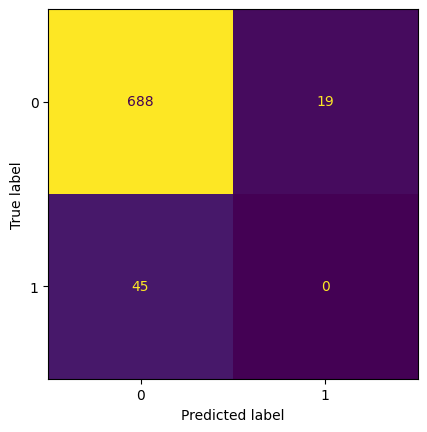

In [243]:
conf = ConfusionMatrixDisplay(mtx)
conf.plot(colorbar=False);

As you can see from the image above, our model got
- 688 True Positives
- 0 True Negatives
- 45 False Negatives
- 19 False Positives

This means that, while our model did well detecting images with spores carryng a decease, it still got confused with a few images. This could potentially result in having a farmer spray some unnecessary pesticide in its farm or doing nothing at all while it should be taking action.

Let's examine a few other measures that help us understand the performance of our model.

### 4.2 Precision

**What is Precision?**
> Precision measures the percentage of samples that are correctly identified as positive out of all samples that the model identified as positive. In other words, it measures the proportion of true positives among all the samples that the model classified as positive.

$precision = \frac{TP}{TP + FP}$

Given the definition above, a high precision means that the model is good at avoiding false positives. Let's evaluate the precision of ours.

In [246]:
round(
    m.precision_score(
        df_merged.class_truth, 
        df_merged.class_pred, 
        pos_label='Alternaria spp.'
    ) * 100,
    2
)

93.86

With a precision score of 93.86%, our models does very well at correctly classifying spores that carry out deceases while avoiding misclassifying those which don't have it.

### 4.3 Recall/Sensitivity

**What is Recall or Sencitivity?**
> Recall measures the percentage of all positive items that are correctly identified by the model. In other words, it measures the proportion of true positives that the model correctly identified among all the samples that are actually positive.

This means that if a model has a high recall it will be good at avoiding false negatives.

$recall = \frac{TP}{TP + FN}$

Let's evaluate the recall of our model.

In [ ]:
m.recall_score(df_merged.class_truth, df_merged.class_pred, pos_label='Alternaria spp.')

0.9731258840169731

### 4.4 F1 Score

**What is an F1 Score?**

> The F1 score is a measure of a model's accuracy that combines the precision and recall metrics into a single score. It takes into account both false positives and false negatives, making it a useful metric for evaluating models that deal with imbalanced classes.

- $tp$ - True Positives
- $tn$ - True Negatives
- $fp$ - False Positives
- $fn$ - False Negatives

**F1 Formula**

$f1 = 2\frac{ (precision)(recall)}{precision + recall} = \frac{2 tp}{2tp + fp + fn}$

Let's get the F1 Score for our model.

In [248]:
round(
    m.f1_score(
        df_merged.class_truth, 
        df_merged.class_pred, 
        pos_label='Alternaria spp.'
    ) * 100,
    2
)

95.56

As with precision and recall, the higher the score the better. In particular, a higher score means that our model can perform well on imbalanced data.

### 4.5 Accuracy

**What is Accuracy?**
> Accuracy is a metric used to evaluate how well a classification model is able to correctly predict the class label of unseen data points, and it is defined as the ratio of the number of correct predictions to the total number of predictions. 

While accuracy can be a very useful metric, it mostly shines with balanced datasets. Hence why we used more appropriate metrics such as precision, recall, or F1 score above.

Nonetheless, let's get the precision for our model.

In [249]:
round(
    m.accuracy_score(
        df_merged.class_truth, 
        df_merged.class_pred
    ) * 100,
    2
)

91.49

### 4.6 Specificity

One last metric we could have calculated is Specificity.

**What is Specificity?**
> Specificity is a metric used to evaluate the ability of a classification model to correctly predict the negative class, and it is represented as the proportion of true negative predictions over the total number of actual negatives.

The above definition tells us that this metric is particularly useful in cases where the negative class is more important, such as in medical diagnosis, where correctly identifying healthy patients is critical. The problem with our analysis is that our **True Negatives** are 0, therefore, our specitivity will be $0$.

Similar to accuracy, specificity may not be a sufficient metric in cases of class imbalance, but it is still useful for understanding the performance of our model.

Even though we know it is $0$, let's use the formula to calculate it.

$specificity = \frac{tn}{tn + fp}$

In [253]:
mtx[1][1] / (mtx[1][1] + mtx[0][1])

0.0

### 4.7 Autoevaluation

Let's start by creating functions for our metrics and finalize this section by turning these into a script as we have done before.

In [315]:
def get_metrics(df, y_truth, y_pred, label):
    return dict(
        precision=round(m.precision_score(df[y_truth], df[y_pred], pos_label=label) * 100, 2),
        recall=round(m.recall_score(df[y_truth], df[y_pred], pos_label=label) * 100, 2),
        f1_score=round(m.f1_score(df[y_truth], df[y_pred], pos_label=label) * 100, 2),
        accuracy=round(m.accuracy_score(df[y_truth], df[y_pred]) * 100, 2)
    )

In [316]:
metrics = get_metrics(df_merged, "class_truth", "class_pred", 'Alternaria spp.')
metrics

{'precision': 93.86, 'recall': 97.31, 'f1_score': 95.56, 'accuracy': 91.49}

In [317]:
def confused_mtx(df, y_truth, y_pred):
    return m.confusion_matrix(df[y_truth], df[y_pred])

In [318]:
conf_mtx = confused_mtx(df_merged, "class_truth", "class_pred")
conf_mtx

array([[688,  19],
       [ 45,   0]])

In [319]:
def generate_config(metrics, mtx, path=None, file_name=None):
    conf = OmegaConf.create({
        "facts": {
            "sample_size": int(sum(sum(mtx))),
            "healthy_preds": int(mtx[0][0]),
            "wrong_preds": int(mtx[1][0] - mtx[0][1])
        },
        "metrics": {k: float(v) for k, v in metrics.items()},
        "matrix": {
            "true_pos": int(mtx[0][0]),
            "true_neg": int(mtx[1][1]),
            "false_pos": int(mtx[0][1]),
            "false_neg": int(mtx[1][0])
        }
    })
    
    print(OmegaConf.to_yaml(conf))

In [320]:
generate_config(metrics, mtx)

facts:
  sample_size: 752
  healthy_preds: 688
  wrong_preds: 26
metrics:
  precision: 93.86
  recall: 97.31
  f1_score: 95.56
  accuracy: 91.49
matrix:
  true_pos: 688
  true_neg: 0
  false_pos: 19
  false_neg: 45



We can now put everything together and finalize our last script.

In [323]:
%%writefile src/evaluate.py

import sklearn.metrics as m
import pandas as pd
from os.path import join
from omegaconf import OmegaConf
from extract import load_table

def get_metrics(df, y_truth, y_pred, label):
    return dict(
        precision=round(m.precision_score(df[y_truth], df[y_pred], pos_label=label) * 100, 2),
        recall=round(m.recall_score(df[y_truth], df[y_pred], pos_label=label) * 100, 2),
        f1_score=round(m.f1_score(df[y_truth], df[y_pred], pos_label=label) * 100, 2),
        accuracy=round(m.accuracy_score(df[y_truth], df[y_pred]) * 100, 2)
    )

def confused_mtx(df, y_truth, y_pred):
    return m.confusion_matrix(df[y_truth], df[y_pred])

def generate_config(metrics, mtx, path, file_name):
    conf = OmegaConf.create({
        "facts": {
            "sample_size": int(sum(sum(mtx))),
            "healthy_preds": int(mtx[0][0]),
            "wrong_preds": int(mtx[1][0] - mtx[0][1])
        },
        "metrics": {k: float(v) for k, v in metrics.items()},
        "matrix": {
            "true_pos": int(mtx[0][0]),
            "true_neg": int(mtx[1][1]),
            "false_pos": int(mtx[0][1]),
            "false_neg": int(mtx[1][0])
        }
    })
    
    OmegaConf.save(conf, join(path, file_name))
    
    print(f"Config Successfully saved as {join(path, file_name)}")

if __name__ == "__main__":
    df = load_table(join("data", "processed"), "combined_table.parquet")
    metrics = get_metrics(df, "class_truth", "class_pred", 'Alternaria spp.')
    conf_mtx = confused_mtx(df, "class_truth", "class_pred")
    generate_config(metrics, conf_mtx, join("src", "configs"), "config.yml")

Overwriting src/evaluate.py


Let's test it to make sure everything is working correctly.

In [324]:
!python src/evaluate.py

Config Successfully saved as src/configs/config.yml


In [325]:
!cat src/configs/config.yml

facts:
  sample_size: 752
  healthy_preds: 688
  wrong_preds: 26
metrics:
  precision: 93.86
  recall: 97.31
  f1_score: 95.56
  accuracy: 91.49
matrix:
  true_pos: 688
  true_neg: 0
  false_pos: 19
  false_neg: 45


## 5. Building a Pipeline

We will be using dvc to create a reproducible pipeline, version, and cache artefacts.

In order for us to create a pipeline via different stages, we need to have run the following commands first (no need to do this since you probably cloned this repo):
- `dvc init`
- `dvc remote add -d local_data_lake data`

Now, we are ready to create our pipeline using `dvc stage add`, which will create a `dvc.yml` file which will track the different stages of our pipeline. Using the command `dvc repro` will run our pipeline and create a file called, `dvc.lock`, which will take care of versioning each component of it.

If you want to run these files for the first time you can either remove them with 
```sh
rm dvc.yml dvc.lock
```
or you can add `--force` in each of the steps, for example,
```sh
dvc stage add --force --name extract
```
or you can change some of the parameters like
```sh
dvc stage add --force --name extract \
    --deps data/raw/ground_truth/ \
    --deps data/raw/predictions/ \
    --outs your/data/dir/and/file.parquet \
    --outs your/data/dir/and/file.parquet \
    python src/extract.py
```

In [16]:
%%bash

dvc stage add --force --name extract \
    --deps data/raw/ground_truth/ \
    --deps data/raw/predictions/ \
    --outs data/interim/actuals_table.parquet \
    --outs data/interim/predicted_table.parquet \
    python src/extract.py

Modifying stage 'extract' in 'dvc.yaml'

To track the changes with git, run:

	git add dvc.yaml

To enable auto staging, run:

	dvc config core.autostage true


Let's make sure our pipeline works by calling `dvc repro`.

In [17]:
!cat dvc.yaml

stages:
  extract:
    cmd: python src/extract.py
    deps:
    - data/raw/ground_truth/
    - data/raw/predictions/
    outs:
    - data/interim/actuals_table.parquet
    - data/interim/predicted_table.parquet


In [18]:
!dvc repro

Running stage 'extract':                                                        
> python src/extract.py
Successfully loaded the actuals_table.parquet table!
Successfully loaded the predicted_table.parquet table!
Generating lock file 'dvc.lock'                                                 
Updating lock file 'dvc.lock'

To track the changes with git, run:

	git add dvc.lock

To enable auto staging, run:

	dvc config core.autostage true
Use `dvc push` to send your updates to remote storage.
